In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, KNNBasic, accuracy
from surprise.model_selection import train_test_split
from collections import defaultdict
import pickle
import os

In [ ]:
class MovieRecommender:
    """
    Hệ thống gợi ý phim dựa trên Collaborative Filtering sử dụng KNN.
    Tích hợp:
        - Load & preprocess dữ liệu MovieLens 100K
        - Train KNN (user-based/item-based)
        - Tính RMSE, Precision/Recall/F1
        - Top-N recommendation trực tiếp từ similarity matrix
        - Biểu đồ phân tích dữ liệu và kết quả
    """
    
    def __init__(self, data_path=r"D:\Project_20\data\input\ml-100K"):
        """Khởi tạo MovieRecommender"""
        self.data_path = data_path
        self.models_dir = r"D:\Project_20\data\output\RS_save"
        os.makedirs(self.models_dir, exist_ok=True)

        # Biến lưu trữ dữ liệu
        self.raw_ratings = None      # Bản gốc chưa xử lý
        self.ratings = None          # Bản ratings đã xử lý
        self.movies = None           # Thông tin movie
        self.trainset = None
        self.testset = None
        self.data = None
        self.default_k = 10          # Số lượng neighbor mặc định
        self.results_df = None       # DataFrame lưu kết quả train KNN
        self.all_recommendations = {}  # Để lưu gợi ý cho tất cả user

    # ----------------- LOAD & PREPROCESS -----------------
    def load_data(self, verbose=True):
        """Load dữ liệu MovieLens 100K và xử lý cơ bản"""
        # Load ratings
        ratings_file = os.path.join(self.data_path, 'ratings.csv')
        self.ratings = pd.read_csv(ratings_file)
        self.raw_ratings = self.ratings.copy()
        if verbose:
            print(f"Số lượng rating ban đầu: {len(self.raw_ratings)}")

        # Chuẩn hóa tên cột
        self.ratings.rename(columns={'userId':'user_id','movieId':'movie_id'}, inplace=True)

        # Load movies
        movies_file = os.path.join(self.data_path, 'movies.csv')
        self.movies = pd.read_csv(movies_file, encoding='latin-1')
        self.movies.rename(columns={'movieId':'movie_id','title':'title'}, inplace=True)

        # Tiền xử lý dữ liệu
        self.preprocess_data(verbose)

    def preprocess_data(self, verbose=True):
        """Xử lý dữ liệu: loại bỏ NaN, rating ngoài 1-5, duplicate"""
        # Chỉ giữ rating trong khoảng 1-5
        self.ratings = self.ratings[self.ratings['rating'].between(1,5)]
        self.ratings.dropna(subset=['user_id','movie_id','rating'], inplace=True)

        # Nếu có duplicate, lấy trung bình rating
        if self.ratings.duplicated(subset=['user_id','movie_id']).any():
            self.ratings = self.ratings.groupby(['user_id','movie_id'], as_index=False)['rating'].mean()

        # Giữ movies có trong ratings
        self.movies = self.movies[self.movies['movie_id'].isin(self.ratings['movie_id'])]

        # Thống kê số lượng rating bị loại bỏ
        removed = len(self.raw_ratings) - len(self.ratings)
        removed_pct = removed / len(self.raw_ratings) * 100
        print(f"Số lượng rating sau xử lý: {len(self.ratings)}")
        print(f"Đã loại bỏ {removed} rating ({removed_pct:.2f}%)")

        # Lưu dữ liệu đã xử lý
        self.ratings.to_csv(os.path.join(self.models_dir,'ratings_processed.csv'), index=False)
        self.movies.to_csv(os.path.join(self.models_dir,'movies_processed.csv'), index=False)

        if verbose:
            print(f"Số user: {self.ratings['user_id'].nunique()} | Số phim: {self.ratings['movie_id'].nunique()}")
            print(f"Rating trung bình: {self.ratings['rating'].mean():.2f}")

    # ----------------- PREPARE DATA FOR SURPRISE -----------------
    def prepare_surprise_data(self, verbose=True):
        """Chuyển dữ liệu sang định dạng của Surprise và chia tập train/test"""
        reader = Reader(rating_scale=(1,5))
        self.data = Dataset.load_from_df(self.ratings[['user_id','movie_id','rating']], reader)
        self.trainset, self.testset = train_test_split(self.data, test_size=0.2, random_state=42)

        n_train = sum(1 for _ in self.trainset.all_ratings())
        n_test = len(self.testset)
        total = n_train + n_test
        if verbose:
            print("Train/Test đã chia xong")
            print(f"Số mẫu train: {n_train} ({n_train/total*100:.2f}%)")
            print(f"Số mẫu test: {n_test} ({n_test/total*100:.2f}%)")

    # ----------------- METRICS -----------------
    def precision_recall_f1_at_k(self, predictions, k, threshold=3.5):
        """
        Tính Precision, Recall, F1-score cho từng user rồi trung bình
        Dùng threshold=3.5 để xác định rating "positive"
        """
        user_est_true = defaultdict(list)
        for uid, _, true_r, est, _ in predictions:
            user_est_true[uid].append((est, true_r))

        precisions, recalls, f1s = [], [], []
        for uid, user_ratings in user_est_true.items():
            user_ratings.sort(key=lambda x: x[0], reverse=True)
            top_k = user_ratings[:k]
            n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
            n_prec_k = sum((est >= threshold) for (est, _) in top_k)
            n_rec_k = sum((est >= threshold) and (true_r >= threshold) for (est, true_r) in top_k)
            precision = n_rec_k/n_prec_k if n_prec_k>0 else 0
            recall = n_rec_k/n_rel if n_rel>0 else 0
            f1 = 2*precision*recall/(precision+recall) if (precision+recall)>0 else 0
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)

        return np.mean(precisions), np.mean(recalls), np.mean(f1s)

    # ----------------- TRAIN KNN -----------------
    def train_knn(self, verbose=True):
        """
        Huấn luyện KNN trên các similarity khác nhau
        - similarity: cosine, msd, pearson
        - lưu mô hình
        - tính RMSE train/test và Precision/Recall/F1
        """
        similarities = ['cosine','msd','pearson']
        results = []

        print("\n=== HUẤN LUYỆN KNN CHO TẤT CẢ SIMILARITIES (k=10) ===")
        for sim in similarities:
            sim_options = {'name':sim,'user_based':False,'k':self.default_k,'min_k':1}
            knn = KNNBasic(sim_options=sim_options, verbose=False)
            knn.fit(self.trainset)
            self.save_model(knn,f'knn_{sim}_k{self.default_k}.pkl')

            # Tạo predictions để đánh giá
            predictions_train = knn.test(self.trainset.build_testset())
            predictions_test = knn.test(self.testset)

            # RMSE
            rmse_train = accuracy.rmse(predictions_train, verbose=False)
            rmse_test = accuracy.rmse(predictions_test, verbose=False)

            # Precision/Recall/F1
            p,r,f1 = self.precision_recall_f1_at_k(predictions_test, self.default_k)

            results.append({'similarity':sim,'k':self.default_k,
                            'RMSE_train':rmse_train,'RMSE_test':rmse_test,
                            'Precision':p,'Recall':r,'F1':f1})

            if verbose:
                print(f"Sim={sim} | k={self.default_k} | RMSE_train={rmse_train:.4f} | "
                      f"RMSE_test={rmse_test:.4f} | Precision={p:.4f} | Recall={r:.4f} | F1={f1:.4f}")

        self.results_df = pd.DataFrame(results)
        return self.results_df

    # ----------------- SAVE/LOAD MODEL -----------------
    def save_model(self, model, filename):
        """Lưu mô hình KNN dưới dạng pickle"""
        filepath = os.path.join(self.models_dir, filename)
        with open(filepath,'wb') as f:
            pickle.dump(model,f)

    def load_model(self, filename):
        """Tải mô hình KNN từ pickle"""
        filepath = os.path.join(self.models_dir, filename)
        if os.path.exists(filepath):
            with open(filepath,'rb') as f:
                return pickle.load(f)
        return None

    # ----------------- COMPUTE AND SAVE RECOMMENDATIONS FOR ALL USERS -----------------
    def compute_and_save_all_recommendations(self, model_type='knn_msd', n_recommendations=10, verbose=True): # model_type = 'knn_msd' là giá trị mặc định, để class biết mô hình nào dùng để tính gợi ý
        """
        Tính và lưu gợi ý cho tất cả user để đảm bảo nhất quán với web.
        Lưu vào file recommendations_all_users_{sim}_k10.pkl
        """
        if verbose:
            print(f"\n=== TÍNH VÀ LƯU GỢI Ý CHO USER VỚI {model_type} ===")
        
        all_users = sorted(self.ratings['user_id'].unique())
        all_recs = {}
        
        for user_id in all_users:
            recs = self.get_top_n_recommendations_for_user(user_id, model_type, n_recommendations)
            if recs:
                all_recs[user_id] = recs
        
        # Lưu vào file
        sim = model_type.split('_')[1]
        filepath = os.path.join(self.models_dir, f'recommendations_all_users_{sim}_k{self.default_k}.pkl')
        with open(filepath, 'wb') as f:
            pickle.dump(all_recs, f)
        
        if verbose:
            print(f"Đã lưu gợi ý cho {len(all_recs)} user vào {filepath}")

    def get_top_n_recommendations_for_user(self, user_id, model_type, n_recommendations):
        """Hàm phụ để tính gợi ý cho một user."""
        model = self.load_model(f'{model_type}_k{self.default_k}.pkl')
        if model is None:
            return None
        
        try:
            inner_uid = self.trainset.to_inner_uid(user_id)
        except ValueError:
            return None
        
        seen_items = set([item for item, _ in self.trainset.ur[inner_uid]])
        all_items = set(range(self.trainset.n_items))
        unseen_items = list(all_items - seen_items)[:100]  # Giới hạn scan
        
        predictions = []
        for inner_iid in unseen_items:
            raw_iid = self.trainset.to_raw_iid(inner_iid)
            pred_rating = model.predict(user_id, raw_iid).est
            movie_title = self.movies[self.movies['movie_id'] == raw_iid]['title'].values[0]
            predictions.append((raw_iid, movie_title, pred_rating))
        
        predictions.sort(key=lambda x: x[2], reverse=True)
        return predictions[:n_recommendations]

    # ----------------- GET RECOMMENDATIONS (LOAD FROM SAVED FILE) -----------------
    def get_top_n_recommendations(self, user_id, model_type='knn_msd', n_recommendations=5, verbose=True): # model_type = 'knn_msd' là giá trị mặc định, để class biết mô hình nào dùng để tính gợi ý
        """
        Load gợi ý đã lưu từ file để đảm bảo nhất quán với web.
        Nếu chưa load, load trước.
        """
        sim = model_type.split('_')[1]
        filepath = os.path.join(self.models_dir, f'recommendations_all_users_{sim}_k{self.default_k}.pkl')
        if not self.all_recommendations:
            if os.path.exists(filepath):
                with open(filepath, 'rb') as f:
                    self.all_recommendations = pickle.load(f)
            else:
                print(f"Không tìm thấy file gợi ý: {filepath}")
                return None
        
        recommendations = self.all_recommendations.get(user_id)
        if recommendations is None:
            print(f"User {user_id} không có gợi ý đã lưu")
            return None
        
        # Giới hạn n_recommendations nếu cần
        recommendations = recommendations[:n_recommendations]
        
        if verbose:
            print(f"\n=== TOP {n_recommendations} RECOMMENDATIONS FOR USER {user_id} ===")
            for i,(title) in enumerate(recommendations,1):
                #print(f"{i}. {title} | Predicted Rating: {est:.2f}")
                print(f"{i}. {title}")
        
        return recommendations

    # ----------------- PLOTS -----------------
    def plot_analysis(self):
        """
        Vẽ các biểu đồ phân tích:
        1. Rating trước/sau xử lý
        2. Phân bố rating trên User/Movie
        3. Train/Test sample count
        4. So sánh RMSE train/test
        5. Sparse matrix user-item (minh họa 50x50)
        """
        sns.set_style("whitegrid")
        palette = sns.color_palette("Set2")
        fig, axs = plt.subplots(2,2,figsize=(14,12))
        fig.tight_layout(pad=5.0)

        # --- 1. Rating raw vs processed ---
        plt.sca(axs[0,0])
        sns.kdeplot(self.raw_ratings['rating'],color=palette[0],label='Trước xử lý')
        sns.kdeplot(self.ratings['rating'],color=palette[1],label='Sau xử lý')
        plt.title('Rating Trước/Sau Xử Lý'); plt.legend()

        # --- 2. Phân bố số rating User/Movie ---
        plt.sca(axs[0,1])
        sns.kdeplot(self.ratings['user_id'].value_counts(),label='User',color=palette[2])
        sns.kdeplot(self.ratings['movie_id'].value_counts(),label='Movie',color=palette[3])
        plt.title('Phân bố số Rating trên User/Movie'); plt.legend()

        # --- 3. Train/Test count ---
        plt.sca(axs[1,0])
        sns.barplot(x=['Train','Test'],
                    y=[sum(1 for _ in self.trainset.all_ratings()),len(self.testset)],
                    palette=[palette[4],palette[5]])
        plt.title('Số lượng Train/Test')

        # --- 4. So sánh RMSE train/test ---
        plt.sca(axs[1,1])
        if self.results_df is not None:
            x = self.results_df['similarity']
            width = 0.35
            plt.bar(np.arange(len(x)) - width/2, self.results_df['RMSE_train'], width, label='RMSE Train', color=palette[0])
            plt.bar(np.arange(len(x)) + width/2, self.results_df['RMSE_test'], width, label='RMSE Test', color=palette[1])
            plt.xticks(np.arange(len(x)), x)
            plt.ylabel("RMSE")
            plt.title("So sánh RMSE Train/Test")
            plt.legend()
        plt.show()

        # --- 5. Sparse matrix plot (50x50 minh họa) ---
        plt.figure(figsize=(8,6))
        user_item_matrix = self.ratings.pivot_table(index='user_id',columns='movie_id',values='rating').fillna(0)
        sns.heatmap(user_item_matrix.iloc[:50,:50],cmap='YlGnBu')
        plt.title('Heatmap User-Item (50x50 minh họa)')
        plt.show()

Số lượng rating ban đầu: 100004
Số lượng rating sau xử lý: 98903
Đã loại bỏ 1101 rating (1.10%)
Số user: 671 | Số phim: 8972
Rating trung bình: 3.58
Train/Test đã chia xong
Số mẫu train: 79122 (80.00%)
Số mẫu test: 19781 (20.00%)

=== HUẤN LUYỆN KNN CHO TẤT CẢ SIMILARITIES (k=10) ===
Sim=cosine | k=10 | RMSE_train=0.8820 | RMSE_test=0.9555 | Precision=0.6135 | Recall=0.4954 | F1=0.4877
Sim=msd | k=10 | RMSE_train=0.4533 | RMSE_test=0.8988 | Precision=0.6589 | Recall=0.5114 | F1=0.5140
Sim=pearson | k=10 | RMSE_train=0.6666 | RMSE_test=0.9509 | Precision=0.6356 | Recall=0.4846 | F1=0.4938


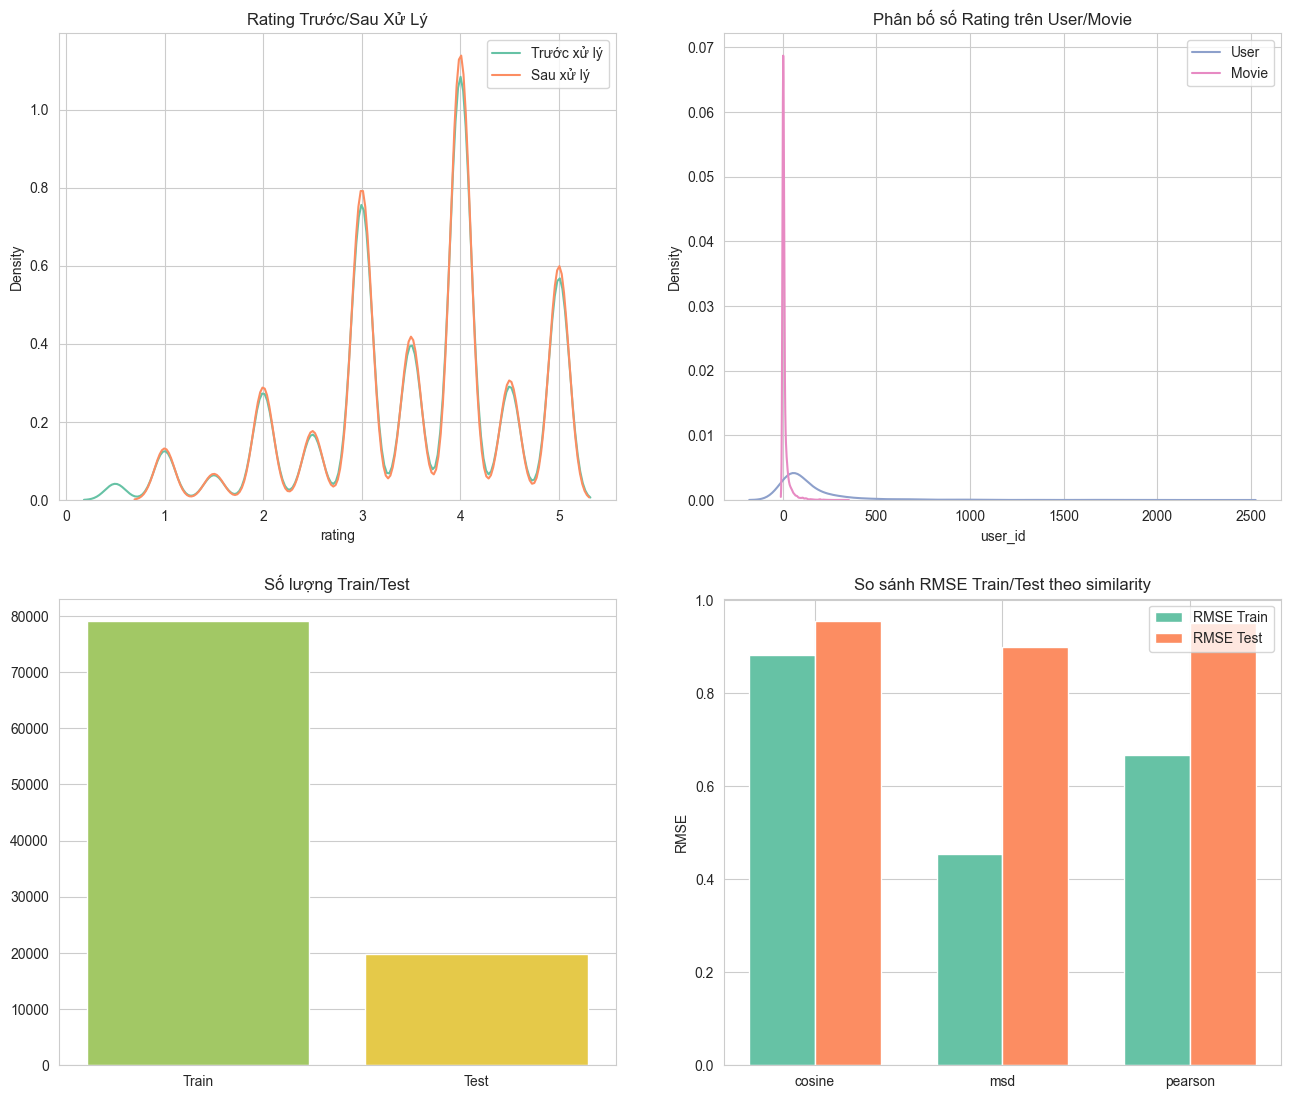

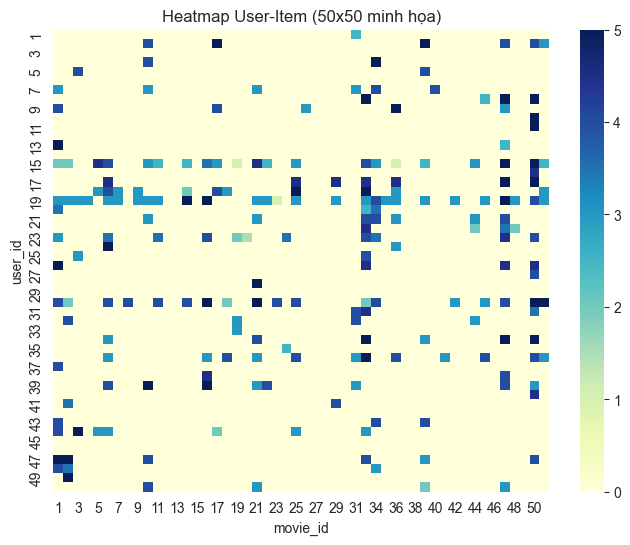


Mô hình tốt nhất dựa trên F1: similarity=msd, k=10

=== TÍNH VÀ LƯU GỢI Ý CHO TẤT CẢ USER VỚI knn_msd ===
Đã lưu gợi ý cho 671 user vào D:\Project_20\data\output\RS_save\recommendations_all_users_msd_k10.pkl

=== TOP 10 RECOMMENDATIONS FOR USER 10 (TỪ FILE LƯU) ===
1. (3736, 'Ace in the Hole (Big Carnival, The) (1951)', 4.1136468209209065)
2. (7323, 'Good bye, Lenin! (2003)', 3.99414814838004)
3. (44555, 'Lives of Others, The (Das leben der Anderen) (2006)', 3.9739202987807696)
4. (593, 'Silence of the Lambs, The (1991)', 3.9604272603324855)
5. (1269, 'Arsenic and Old Lace (1944)', 3.937147634048473)
6. (54881, 'King of Kong, The (2007)', 3.9370979437490283)
7. (8917, 'Team America: World Police (2004)', 3.930436813129761)
8. (515, 'Remains of the Day, The (1993)', 3.891053527836367)
9. (415, 'Another Stakeout (1993)', 3.8898211472648256)
10. (296, 'Pulp Fiction (1994)', 3.889004821551224)


In [6]:
# ----------------- RUN -----------------
if __name__ == "__main__":
    recommender = MovieRecommender()
    recommender.load_data(verbose=True)
    recommender.prepare_surprise_data(verbose=True)
    results_df = recommender.train_knn(verbose=True)
    recommender.plot_analysis()

    # Tính và lưu gợi ý cho tất cả user với model tốt nhất
    best_row = results_df.loc[results_df['F1'].idxmax()]
    print(f"\nMô hình tốt nhất dựa trên F1: similarity={best_row['similarity']}, k={best_row['k']}")
    recommender.compute_and_save_all_recommendations(model_type=f"knn_{best_row['similarity']}", verbose=True)
    
    # Demo gợi ý từ file lưu
    recommender.get_top_n_recommendations(
        user_id=10, 
        model_type=f"knn_{best_row['similarity']}", 
        n_recommendations=10, verbose=True)